In [1]:
import pandas as pd
import numpy as np
import os
from scipy.misc import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import warnings
import seaborn as sns

%matplotlib inline



In [2]:
directory = os.path.expanduser('~/Downloads/train/')
images = []
files = []

# loop over directories: 
for i in range(1, 50001):
    name = str(i) + '.png'
    file = os.path.join(directory, name)
    images.append(mpimg.imread(file))

In [3]:
# Read in label
df = pd.read_csv('~/Downloads/trainLabels.csv') # read in the csv file
labels = df.label.values

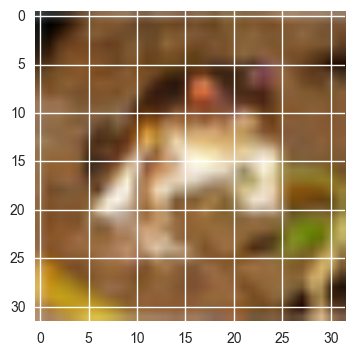

In [4]:
imgplot = plt.imshow(images[0])

In [5]:
# convert to luminance, thanks http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

for i in range(0, 50000):
    images[i] = rgb2gray(images[i])

In [6]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


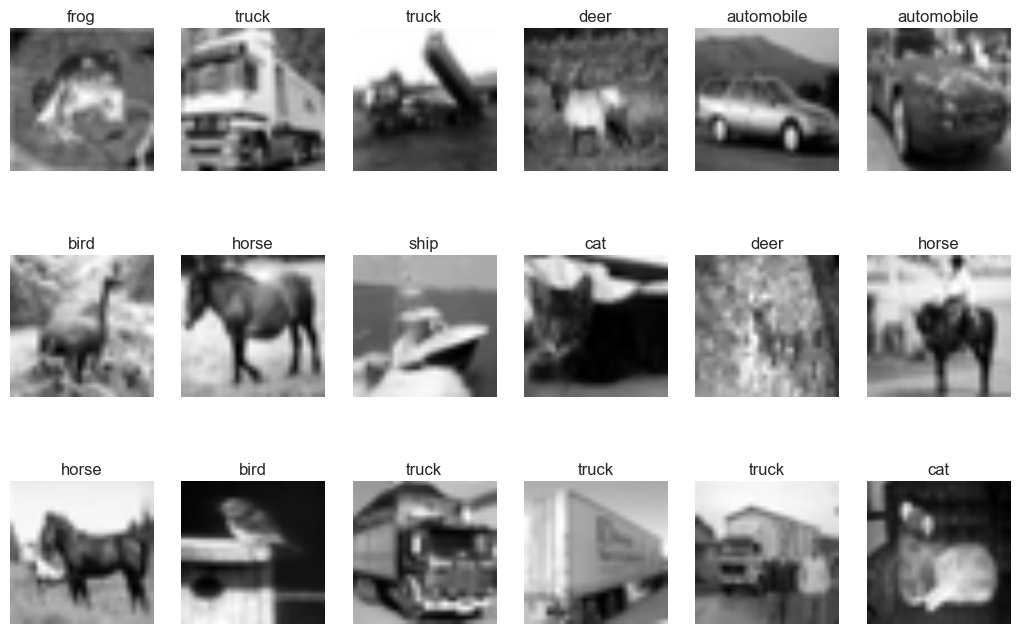

In [7]:
plot_gallery(images, labels, 32, 32) # defaults to showing a 3 by 6 subset of the faces

## Full CPA

In [8]:
# Linearization
img_concat = []
for image in images: 
    img_concat.append(np.concatenate(image))

In [9]:
img_concat[0].shape

(1024,)

In [10]:
# img_concat_arr = np.array(img_concat)
print(len(img_concat))
print(np.array(img_concat).shape)

50000
(50000, 1024)


In [11]:
# get some of the specifics of the dataset
# y = lfw_people.target
X = np.array(img_concat[0:5000]) 
names = labels[0:5000]

n_samples, n_features = X.shape
h, w = 32, 32
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {}by{}".format(h,w))
print (125*94) # the size of the images are the size of the feature vectors

n_samples: 5000
n_features: 1024
n_classes: 5000
Original Image Sizes 32by32
11750


In [12]:
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X)
eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenfaces from 5000 faces
CPU times: user 4.12 s, sys: 169 ms, total: 4.29 s
Wall time: 2.41 s


In [13]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        

plot_explained_variance(pca)

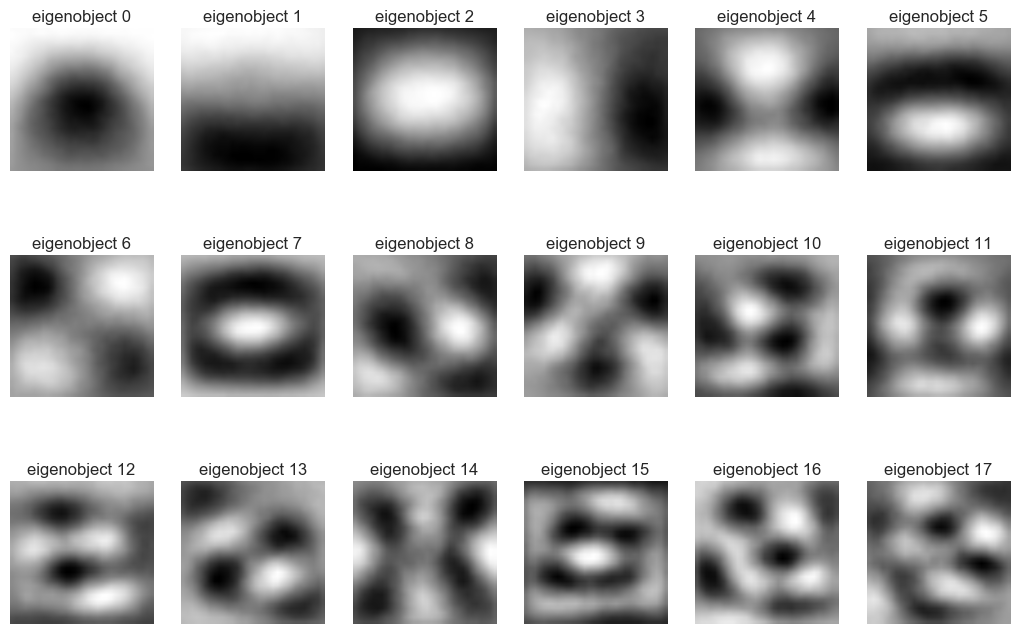

In [14]:
eigenface_titles = ["eigenobject %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [15]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 4    
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct])

/Users/erikgabrielsen/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



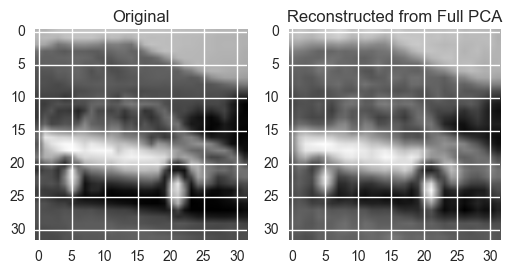

In [16]:
plt.subplot(1,2,1)
plt.imshow(X[4].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')

In [17]:
from sklearn.decomposition import RandomizedPCA

n_components = 300
print ("Extracting the top %d eigenvalues from %d objects" % (
    n_components, X.shape[0]))

rpca = RandomizedPCA(n_components=n_components)
%time rpca.fit(X)
eigenfaces = rpca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenvalues from 5000 objects
CPU times: user 2.87 s, sys: 242 ms, total: 3.11 s
Wall time: 2.19 s


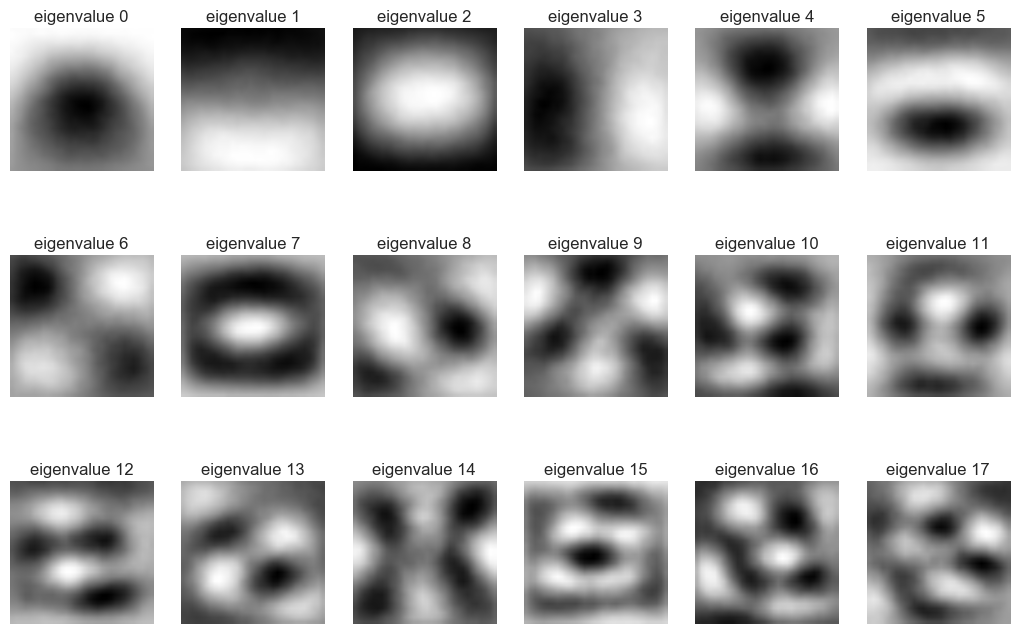

In [18]:
eigenface_titles = ["eigenvalue %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

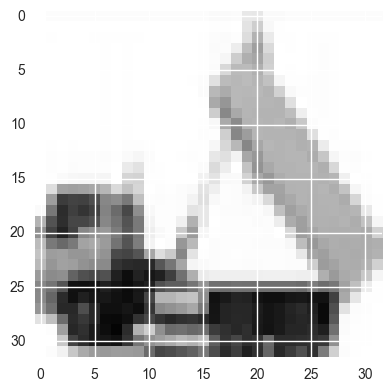

In [19]:
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)

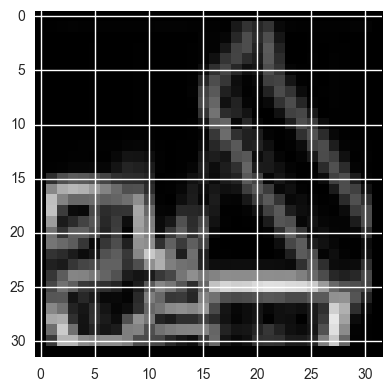

In [20]:
from skimage.filters import sobel_h, sobel_v

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)

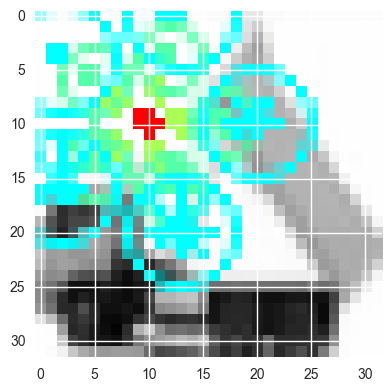

In [21]:
from skimage.feature import daisy

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)

In [22]:
features = daisy(img,step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(2, 2, 72)
288


In [23]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(h,w))
test_feature.shape

CPU times: user 10.4 ms, sys: 841 µs, total: 11.3 ms
Wall time: 20.3 ms


(416,)

In [24]:
0.019 * len(X) # approximate how long it miay run

95.0

In [25]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

CPU times: user 26 s, sys: 405 ms, total: 26.4 s
Wall time: 28.9 s
(5000, 416)


In [26]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features,n_jobs=-1)

CPU times: user 722 ms, sys: 6.55 s, total: 7.27 s
Wall time: 9.85 s


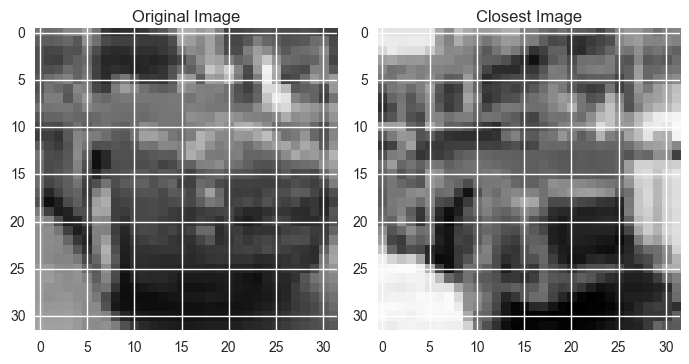

In [27]:
import copy
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")

In [28]:
from ipywidgets import fixed
from ipywidgets import widgets
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)))
    plt.title("Original Image: "+names[idx1])

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)))
    plt.title("Closest Image:  "+names[idx2])
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)))
    plt.title("Next Closest Image: "+names[idx3])
    
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

/Users/erikgabrielsen/anaconda3/lib/python3.5/site-packages/traitlets/traitlets.py:565: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



<function __main__.closest_image>

In [29]:
df = pd.DataFrame(X.T, columns=names)
# add in the class targets and names
# df['target'] = np.array(target).astype(np.int)
print (df.info())

print(X.shape)
print(X.T.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Columns: 5000 entries, frog to frog
dtypes: float64(5000)
memory usage: 39.1 MB
None
(5000, 1024)
(1024, 5000)


frog     truck     truck      deer  automobile  automobile      bird  \
0  0.240067  0.671620  1.000000  0.094851    0.702204    0.466388  0.704055   
1  0.176427  0.523910  0.992157  0.130145    0.694361    0.427831  0.472663   
2  0.188345  0.404992  0.992157  0.134067    0.724157    0.441451  0.524204   
3  0.222816  0.396357  0.992157  0.144702    0.753184    0.520557  0.566380   
4  0.306200  0.510267  0.992157  0.152545    0.760875    0.528839  0.576333   

      horse      ship       cat    ...          dog  airplane     truck  \
0  0.130835  0.684980  0.486173    ...     0.812310  0.776212  0.598980   
1  0.133114  0.675518  0.402161    ...     0.800545  0.778471  0.573149   
2  0.160992  0.666502  0.363882    ...     0.725588  0.795286  0.937051   
3  0.295949  0.672365  0.389604    ...     0.253843  0.797353  0.978078   
4  0.299424  0.684898  0.395102    ...     0.135165  0.838635  0.975329   

   automobile       cat      ship     horse       dog      deer      frog  
0    0.126020  0.988235  0.767412  0.309659  0.635859  0.586353  0.135816  
1    0.132133  1.000000  0.829753  0.306184  0.785157  0.595537  0.143937  
2    0.206894  1.000000  0.810145  0.302263  0.767169  0.566678  0.220024  
3    0.338431  1.000000  0.827451  0.300408  0.780384  0.555361  0.282769  
4    0.492435  1.000000  0.833675  0.300855  0.781153  0.619773  0.252122  

[5 rows x 5000 columns]

In [30]:
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

target = [1]*1024

y = target
target_names = names

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=2)
X_lda = lda.fit(X.T, y) # fit data and then transform it
X_ldat = X_lda.transform(X.T)
# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)
print(X_ldat)

pca: [[ 0.05054877  0.05036621  0.05040056 ...,  0.02876052  0.02931423
   0.02981527]
 [ 0.03108624  0.03152434  0.03205934 ..., -0.03919799 -0.0375136
  -0.03579619]]
lda: []
[]


/Users/erikgabrielsen/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning:

Variables are collinear.



## Gabor Kernels for Feature Extraction


In [31]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, (h,w))
gabr_feature

array([  4.76194356e-01,   8.29979583e-03,  -1.23025893e+00,
         7.32685531e-01,   1.45575186e-01,   1.30153105e-03,
        -8.91551095e-01,   2.01113610e-01,   3.21225380e-01,
         2.53671387e-03,  -1.48335712e+00,   1.41083411e+00,
         4.79149126e-04,   5.49359319e-05,  -8.02441612e-03,
         6.07526639e-01,   4.76198581e-01,   8.28548780e-03,
        -1.23281031e+00,   7.41527622e-01,   1.45779135e-01,
         1.25435076e-03,  -1.12303993e+00,   1.14603372e+00,
         3.24007193e-01,   2.27362385e-03,  -1.45671644e+00,
         1.26785451e+00,   7.71731485e-05,   6.17336232e-05,
        -1.18452767e-01,   5.48711150e+00,   4.76194356e-01,
         8.23475457e-03,  -1.23505634e+00,   7.44317702e-01,
         1.45575186e-01,   1.02465311e-03,  -1.06350336e+00,
         4.85474886e-01,   3.21225380e-01,   1.86384935e-03,
        -1.35005564e+00,   9.29520242e-01,   4.79149126e-04,
         1.31193334e-05,  -5.02161992e-02,   2.26387432e-01,
         4.76198581e-01,

In [32]:
# takes ~3 minutes to run entire dataset
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (h,w))
print(gabor_stats.shape)

CPU times: user 2min 34s, sys: 1.8 s, total: 2min 35s
Wall time: 2min 44s
(5000, 64)


In [33]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(gabor_stats,n_jobs=-1)

CPU times: user 587 ms, sys: 8.93 s, total: 9.52 s
Wall time: 12.9 s


In [34]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

/Users/erikgabrielsen/anaconda3/lib/python3.5/site-packages/traitlets/traitlets.py:565: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



<function __main__.closest_image>

## Kernel PCA- Nonlinear Reduction

In [35]:
from sklearn.decomposition import KernelPCA

n_components = 300
print ("Extracting the top %d eigencalues from %d objects" % (n_components, X.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(X)


Extracting the top 300 eigencalues from 5000 objects
CPU times: user 43.4 s, sys: 1.91 s, total: 45.3 s
Wall time: 25.4 s


KernelPCA(alpha=1.0, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=300,
     remove_zero_eig=False, tol=0)

In [36]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    
    plt.subplot(1,4,4)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

<function __main__.plt_reconstruct>

## Comparing Gabor Features

In [52]:
## create column vector 
cols = np.arange(0,66,1)
col_vector = np.array(names)
cols_test = np.column_stack((col_vector,col_vector))
gabor = np.hstack((gabor_stats, cols_test))
df = pd.DataFrame(gabor, columns=cols)
df.head()


0          1         2         3          4           5         6   \
0  0.414985  0.0151873  0.997814   1.33958   0.126863   0.0022937  0.901147   
1  0.486309  0.0311803  0.266083 -0.726545   0.148667   0.0043284  0.222907   
2  0.501356  0.0796952  0.506289  -1.30794   0.153267  0.00847415  0.454683   
3  0.318379  0.0103046   1.80502   3.89084  0.0973301  0.00138853   1.46852   
4  0.376304  0.0309635  0.413068 -0.368363   0.115038  0.00380832  0.298167   

         7         8           9      ...            56          57  \
0   1.51329  0.279936   0.0033493     ...       0.28236  0.00369319   
1 -0.751098  0.328048    0.006347     ...      0.330889   0.0077034   
2  -1.33252  0.338198    0.023858     ...      0.341127   0.0274241   
3   3.05466  0.214768   0.0024342     ...      0.216628   0.0025535   
4  -0.21173  0.253843  0.00474758     ...      0.256041  0.00671076   

          58        59           60           61          62         63  \
0   0.988361  0.771068  6.72534e-05  4.94922e-05  0.00646399   0.240914   
1 -0.0312266 -0.951356  7.88123e-05  7.97332e-05   0.0455811 -0.0215064   
2   0.467073  -1.19327  8.12509e-05  0.000130121   0.0302848    2.26077   
3    1.53392   2.27188  5.15972e-05  1.86769e-05   0.0422627    1.37379   
4    0.38166 -0.585259  6.09848e-05  9.77567e-05   -0.026744    3.88174   

           64          65  
0        frog        frog  
1       truck       truck  
2       truck       truck  
3        deer        deer  
4  automobile  automobile  

[5 rows x 66 columns]

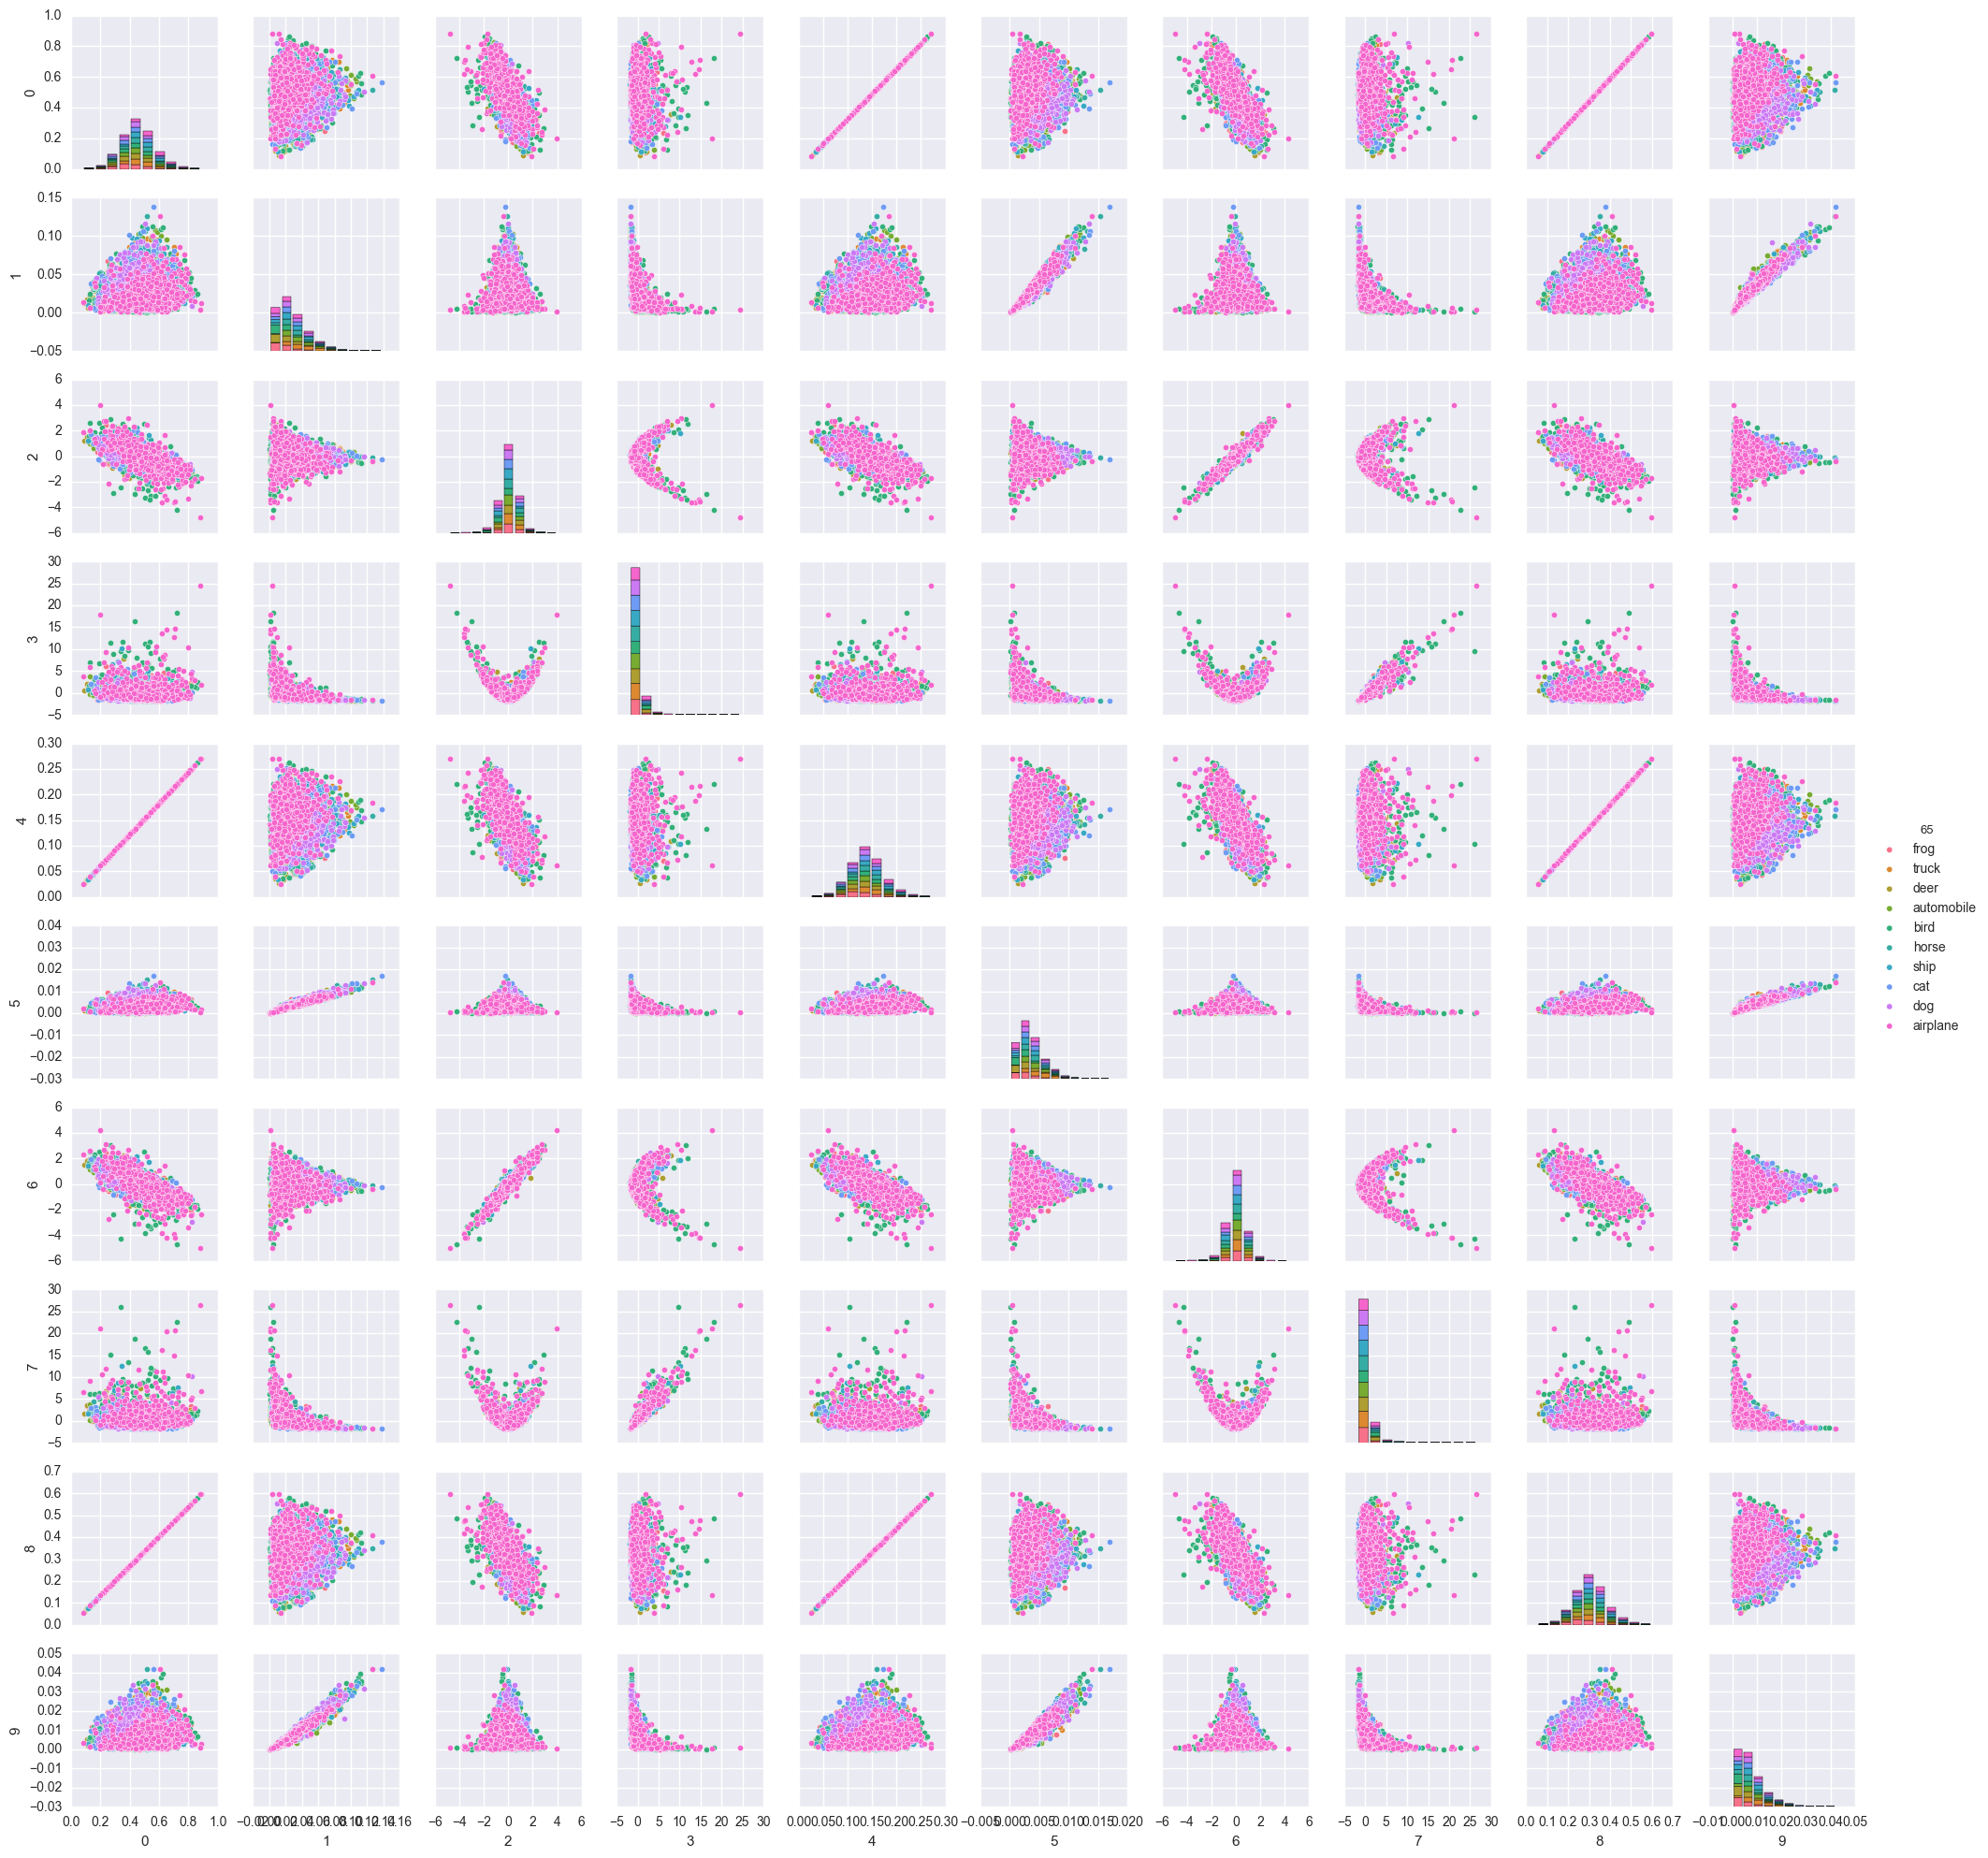

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

deleted_cols = np.arange(5,65,1)

#only use the top 5 gabor values in feature pair plots
df.drop(df.columns[deleted_cols], axis=1, inplace=True)
df.head()
sns.set()
sns.pairplot(df,hue=65, size=2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 64 columns):
0     5000 non-null float64
1     5000 non-null float64
2     5000 non-null float64
3     5000 non-null float64
4     5000 non-null float64
5     5000 non-null float64
6     5000 non-null float64
7     5000 non-null float64
8     5000 non-null float64
9     5000 non-null float64
10    5000 non-null float64
11    5000 non-null float64
12    5000 non-null float64
13    5000 non-null float64
14    5000 non-null float64
15    5000 non-null float64
16    5000 non-null float64
17    5000 non-null float64
18    5000 non-null float64
19    5000 non-null float64
20    5000 non-null float64
21    5000 non-null float64
22    5000 non-null float64
23    5000 non-null float64
24    5000 non-null float64
25    5000 non-null float64
26    5000 non-null float64
27    5000 non-null float64
28    5000 non-null float64
29    5000 non-null float64
30    5000 non-null float64
31    5000 non-null float

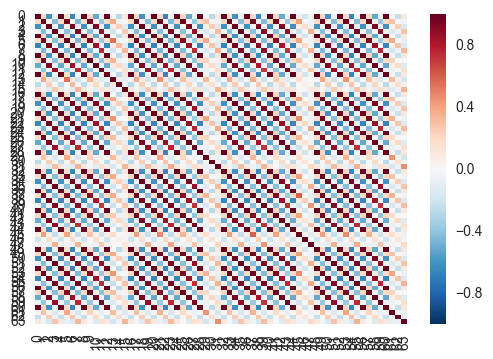

In [51]:
cols = np.arange(0,64,1)
df_no_labels = pd.DataFrame(gabor_stats, columns=cols)
deleted_cols = np.arange(10,64,1)

#only use the top 10 gabor values in feature pair plots
df_no_labels.drop(df_no_labels.columns[deleted_cols], axis=1, inplace=True)
sns.heatmap(df_no_labels.corr())

In [45]:
# get dataframes for truck and bird for comparison
df_copy = df.copy()
df_truck = df_copy[df_copy[65] == 'truck']

df_copy = df.copy()
df_frog = df_copy[df_copy[65] == 'bird']
df_frog.head()


0          1          2     65
6   0.505732  0.0173553   -0.15774  bird
13  0.279947  0.0577793    0.94799  bird
18   0.47897  0.0406575   0.159828  bird
24  0.328494  0.0127476  0.0936351  bird
41  0.713186  0.0194525   -2.43579  bird

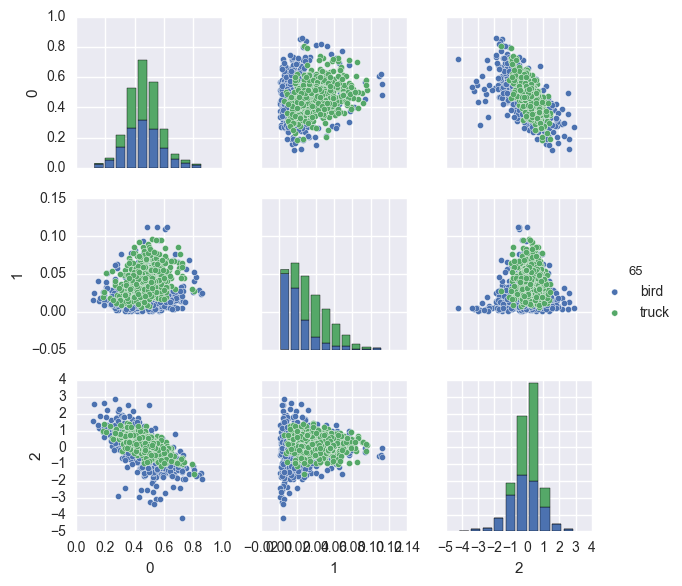

In [46]:
bigdata = df_frog.append(df_truck, ignore_index=True)

sns.set()
sns.pairplot(bigdata,hue=65, size=2)

In [ ]:
def biplot(pca, dat, title=''):
    
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    # 0,1 denote PC1 and PC2; change values for other PCs
    xvector = pca.components_[0] 
    yvector = pca.components_[1]

    tmp = pca.transform(dat.values)
    xs = tmp[:,0] 
    ys = tmp[:,1]

    annotations = [Scatter(x=xs, y=ys, mode ='markers', name='cumulative explained variance')]
    for i in range(len(xvector)):
        txt = list(dat.columns.values)[i]
        annotations.append(
                Scatter(
                    x=[0, xvector[i]*max(xs)],
                    y=[0, yvector[i]*max(ys)],
                    mode='lines+text',
                    text=['', txt],
                    name=txt,
                ))
    
    plotly.offline.iplot({
        "data": annotations,
        "layout": Layout(xaxis=XAxis(title='Principal Component One'), 
                         yaxis=YAxis(title='Principal Component Two'),
                        title=title)
    })


    plt.show()
    
X = gabor_stats
pca = PCA(n_components=4)
pca.fit(X) 
columns = np.arange(0,64,1)
biplot(pca,pd.DataFrame(gabor_stats,columns=columns),'Object Biplot')